In [1]:
#Importing all needed librarys
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from pipetorch.train import *
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from tqdm import tqdm
from torch import nn, optim
import seaborn as sns
import torch.nn.functional as F

# importing the libraries
import pandas as pd
import numpy as np

# for creating validation set
from sklearn.model_selection import train_test_split


import torchvision
from torchvision.datasets import ImageFolder

In [6]:
#Checking wich GPU is beeing used

!nvidia-smi

Failed to initialize NVML: Driver/library version mismatch


In [8]:
#Load data
#data_speaker1_dir = 'dialogue/Dataset/SameVoiceDetection/2d_dataset/speaker1.npy'
data_speaker1_dir = 'dialogue/Leander/outputs/speaker1.npy'
#data_speaker2_dir = 'dialogue/Dataset/SameVoiceDetection/2d_dataset/speaker2.npy'
data_speaker2_dir = 'dialogue/Leander/outputs/speaker2.npy'
#labels_dir = 'dialogue/Dataset/SameVoiceDetection/2d_dataset/labels.npy'
labels_dir = 'dialogue/Leander/outputs/labels.npy'

data_speaker1 = np.load(data_speaker1_dir, allow_pickle = True)
data_speaker2 = np.load(data_speaker2_dir, allow_pickle = True)
data_speaker1 = data_speaker1.reshape((len(data_speaker1),40,len(data_speaker1[0])//40))
data_speaker2 = data_speaker2.reshape((len(data_speaker2),40,len(data_speaker2[0])//40))
labels = np.load(labels_dir, allow_pickle = True)

print(data_speaker1.shape, data_speaker2.shape)
print(labels.shape)

(15200, 40, 16) (15200, 40, 16)
(15200, 1)


In [4]:
#df_data.drop(['isSpeaking'],axis = 1)
X1_train, X1_test, y_train, y_test = train_test_split(data_speaker1, labels, test_size = 0.2, random_state = 23)
X1_train, X1_val, y_train, y_val = train_test_split(X1_train, y_train, test_size = 0.2, random_state = 23)

X2_train, X2_test, y_train, y_test = train_test_split(data_speaker2, labels, test_size = 0.2, random_state = 23)
X2_train, X2_val, y_train, y_val = train_test_split(X2_train, y_train, test_size = 0.2, random_state = 23)

print(type(X1_train))
#print(X_train)

<class 'numpy.ndarray'>


In [5]:
#print(pd.DataFrame(X_train))
X1_train = torch.from_numpy(X1_train).float()
#X1_train = X1_train.unsqueeze_(-1)
#X1_train = X1_train.transpose(1, 2)

X2_train = torch.from_numpy(X2_train).float()
#X2_train = X2_train.unsqueeze_(-1)
#X2_train = X2_train.transpose(1, 2)

y_train = torch.from_numpy(y_train).float()

X1_test = torch.from_numpy(X1_test).float()
#X1_test = X1_test.unsqueeze_(-1)
#X1_test = X1_test.transpose(1, 2) #torch.tensor(X_test.values)

X2_test = torch.from_numpy(X2_test).float()
#X2_test = X2_test.unsqueeze_(-1)
#X2_test = X2_test.transpose(1, 2)

y_test = torch.from_numpy(y_test).float()

X1_val = torch.from_numpy(X1_val).float()
#X1_val = X1_val.unsqueeze_(-1)
#X1_val = X1_val.transpose(1, 2)

X2_val = torch.from_numpy(X2_val).float()
#X2_val = X2_val.unsqueeze_(-1)
#X2_val = X2_val.transpose(1, 2)

y_val = torch.from_numpy(y_val).float()
#print(X_val.shape, X_val)
print(X2_train.shape, y_train.shape)
#print(test_X.shape)
print(X2_train[0])


torch.Size([9728, 40, 16]) torch.Size([9728, 1])
tensor([[-3.3459e+02, -2.5798e+02, -2.2562e+02, -1.9419e+02, -1.6344e+02,
         -1.5055e+02, -1.5625e+02, -1.8095e+02, -2.0028e+02, -2.2531e+02,
         -2.5787e+02, -2.7477e+02, -2.8520e+02, -3.3365e+02, -4.1246e+02,
         -4.4589e+02],
        [ 1.1928e+02,  1.0995e+02,  1.1797e+02,  1.5793e+02,  1.7302e+02,
          1.6231e+02,  1.4530e+02,  1.2890e+02,  1.0998e+02,  9.9373e+01,
          9.8972e+01,  9.0510e+01,  9.6672e+01,  1.0302e+02,  1.0727e+02,
          1.1940e+02],
        [ 4.8070e+01,  3.9309e+01,  4.6488e+01,  4.9425e+01,  1.9633e+01,
         -5.6039e-01, -7.8422e+00, -5.2326e+00, -1.6562e+00,  4.9164e+00,
          1.7679e+01,  1.9902e+01,  2.5681e+01,  3.5001e+01,  5.3924e+01,
          6.9720e+01],
        [ 3.3943e+01,  4.0073e+01,  3.5194e+01,  3.2484e+00, -2.2666e+01,
         -3.1453e+01, -2.1080e+01, -1.4279e+00,  2.0234e+01,  2.7486e+01,
          3.4321e+01,  3.7665e+01,  4.1821e+01,  5.4329e+01,  6.2714

In [8]:
class model(nn.Module):
    def __init__(self,n_features,kernel_size):
        super(model, self).__init__()
        self.conv1 = nn.Conv1d(n_features, 100, kernel_size=3, stride = 1) #1 input channels, 100 output channels
        self.conv2 = nn.Conv1d(100, 320, kernel_size=3, stride = 1) #100 input channels from previous Conv. layer, 75 out
        self.conv3 = nn.Conv1d(320, 160, kernel_size=3, stride = 1) #75 input channels from previous Conv. layer, 50 out
        self.conv4 = nn.Conv1d(160, 80, kernel_size=3, stride = 1) #75 input channels from previous Conv. layer, 50 out
        self.conv5 = nn.Conv1d(80, 60, kernel_size=3, stride = 1) #75 input channels from previous Conv. layer, 50 out
        self.conv5_drop = nn.Dropout2d() #dropout
        
        self.fc1 = nn.Linear(1400, 1) #Fully-connected classifier layer
        #self.fc2 = nn.Linear(50, 1) #Fully-connected classifier layer
        # self.fc3 = nn.Linear(40, 30) #Fully-connected classifier layer
        # self.fc4 = nn.Linear(30, 20) #Fully-connected classifier layer
        # self.fc5 = nn.Linear(20,1) #Fully-connected classifier layer
    
    def forward_one_voice(self, x):
        x = F.relu(F.max_pool1d(self.conv1(x), 2))
        # x = F.relu(F.max_pool1d(self.conv2(x), 2))
        # x = F.relu(F.max_pool1d(self.conv3(x), 2))
        # x = F.relu(F.max_pool1d(self.conv4(x), 2))
        # x = F.relu(F.max_pool1d(self.conv5_drop(self.conv5(x)), 2))
        
        #point A
        x = x.reshape(len(x), -1)
        #print(x.shape)
        batch_size = len(x)
        #print(batch_size)
        #x = self.fc1(x)
        #x = self.fc2(x)
        # x = self.fc3(x)
        # x = self.fc4(x)
        # x = self.fc5(x)
        
        return x
    
    def forward(self, x1, x2):
        x1 = self.forward_one_voice(x1)
        x2 = self.forward_one_voice(x2)
        x = torch.concat([x1, x2], axis = 1)
        x = self.fc1(x)
        #print(x1)
        # #print(x1.data.cpu().numpy()[0])
        #x1 = torch.diff(x1, dim=0)
        #print(x1)
        
        # #x = np.concatenate([x1.detach().cpu(), x2.detach().cpu()], axis=1)
        # #print(x)
        # #print(x1.shape)
        # #x = torch.from_numpy(x).float()

        
        # #point B
        #x = self.forward_that_is_not_going_to_work(x1, x2)
        return torch.sigmoid(x)
    
    def post_forward(self, y): 
        return torch.round(y)
    
CNN = model(X1_train.shape[1],kernel_size = 3)

In [9]:
weight = torch.FloatTensor([1])
criterion = nn.BCELoss()
optimizer = optim.Adam(CNN.parameters(), lr=0.001)

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
X1_train = X1_train.to(device)
X2_train = X2_train.to(device)
y_train = y_train.to(device)
X1_test = X1_test.to(device)
X2_test = X2_test.to(device)
y_test = y_test.to(device)
X1_val = X1_val.to(device)
X2_val = X2_val.to(device)
y_val = y_val.to(device)
CNN = CNN.to(device)
criterion = criterion.to(device)

/opt/jupyterhub/anaconda/lib/python3.9/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272068185/work/c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [ ]:
def calculate_accuracy(y_true, y_pred):
    return (y_true == y_pred).sum().float() / len(y_true)

In [ ]:
def round_tensor(t, decimal_places=3):
    return round(t.item(), decimal_places)

Results = pd.DataFrame(columns = ['Epoch', 'Acc_train', 'Acc_test', 'test_loss', 'train_loss'])
    
for epoch in range(1000):
        optimizer.zero_grad()
        y_pred = CNN(X1_train, X2_train)
        #print(y_pred.shape)
        #y_pred = torch.squeeze(y_pred)
        #y_pred = y_pred.unsqueeze_(-1)
        #print(y_pred.shape, y_train.shape)
        #print(y_pred.shape)
        train_loss = criterion(y_pred, y_train)
        train_loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
        
            train_acc = calculate_accuracy(y_train, CNN.post_forward(y_pred))
        
            y_test_pred = CNN(X1_test, X2_test)

            #y_test_pred = torch.squeeze(y_test_pred)
            
            #y_test_pred = y_test_pred.unsqueeze_(-1)

            test_loss = criterion(y_test_pred, y_test)
        
            test_acc = calculate_accuracy(y_test, CNN.post_forward(y_test_pred))
        
            result = {'Epoch': epoch, 'Acc_train': round_tensor(train_acc), 'Acc_test': round_tensor(test_acc), 'test_loss': round_tensor(test_loss), 'train_loss': round_tensor(train_loss)}

            Results = Results.append(result, ignore_index=True)

            print(
f'''epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
''')
        
        
        


torch.Size([6400, 700])
6400
torch.Size([6400, 700])
6400
torch.Size([2000, 700])
2000
torch.Size([2000, 700])
2000
epoch 0
Train set - loss: 1.054, accuracy: 0.753
Test  set - loss: 2.85, accuracy: 0.898

torch.Size([6400, 700])
6400
torch.Size([6400, 700])
6400
torch.Size([6400, 700])
6400
torch.Size([6400, 700])
6400
torch.Size([6400, 700])
6400
torch.Size([6400, 700])
6400
torch.Size([6400, 700])
6400
torch.Size([6400, 700])
6400
torch.Size([6400, 700])
6400
torch.Size([6400, 700])
6400
torch.Size([6400, 700])
6400
torch.Size([6400, 700])
6400
torch.Size([6400, 700])
6400
torch.Size([6400, 700])
6400
torch.Size([6400, 700])
6400
torch.Size([6400, 700])
6400
torch.Size([6400, 700])
6400
torch.Size([6400, 700])
6400
torch.Size([6400, 700])
6400
torch.Size([6400, 700])
6400
torch.Size([2000, 700])
2000
torch.Size([2000, 700])
2000
epoch 10
Train set - loss: 1.709, accuracy: 0.899
Test  set - loss: 1.873, accuracy: 0.898

torch.Size([6400, 700])
6400
torch.Size([6400, 700])
6400
torch.

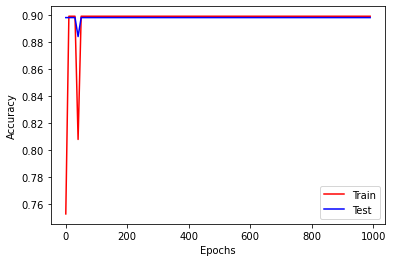

    Epoch  Acc_train  Acc_test  test_loss  train_loss
0     0.0      0.753     0.898      2.850       1.054
1    10.0      0.899     0.898      1.873       1.709
2    20.0      0.899     0.898      1.031       0.929
3    30.0      0.899     0.898      0.558       0.629
4    40.0      0.808     0.884      0.410       0.469
..    ...        ...       ...        ...         ...
95  950.0      0.899     0.898      0.356       0.322
96  960.0      0.899     0.898      0.356       0.322
97  970.0      0.899     0.898      0.356       0.322
98  980.0      0.899     0.898      0.356       0.322
99  990.0      0.899     0.898      0.356       0.322

[100 rows x 5 columns]


In [ ]:
plt.plot(Results.Epoch,Results.Acc_train,'r',Results.Epoch,Results.Acc_test,'b')
plt.legend(['Train','Test'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()
print(Results)

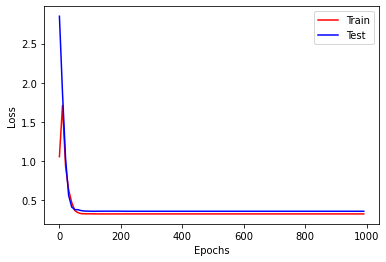

In [ ]:
plt.plot(Results.Epoch,Results.train_loss,'r',Results.Epoch,Results.test_loss,'b')
plt.legend(['Train','Test'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
classes = ['Different Voice', 'Same Voice']
y_pred = CNN(X1_test, X2_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print(classification_report(y_test, y_pred, target_names=classes))

torch.Size([2000, 700])
2000
torch.Size([2000, 700])
2000
                 precision    recall  f1-score   support

Different Voice       0.90      1.00      0.95      1795
     Same Voice       0.00      0.00      0.00       205

       accuracy                           0.90      2000
      macro avg       0.45      0.50      0.47      2000
   weighted avg       0.81      0.90      0.85      2000



/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


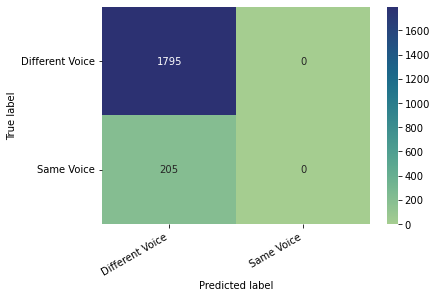

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap= 'crest')
#hmap.color_palette("viridis", as_cmap=True)
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [ ]:
y_pred = CNN(X1_val, X2_val)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_val = y_val.cpu()
print(classification_report(y_val, y_pred, target_names=classes))

torch.Size([1600, 700])
1600
torch.Size([1600, 700])
1600
                 precision    recall  f1-score   support

Different Voice       0.91      1.00      0.95      1454
     Same Voice       0.00      0.00      0.00       146

       accuracy                           0.91      1600
      macro avg       0.45      0.50      0.48      1600
   weighted avg       0.83      0.91      0.87      1600



/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


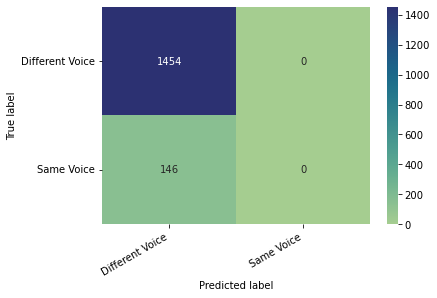

In [ ]:
cm = confusion_matrix(y_val, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap= 'crest')
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [ ]:
#Shutting down the notebook

%%javascript
Jupyter.notebook.session.delete();

UsageError: Line magic function `%%javascript` not found.
